In [1]:
# pick a hmm classifier and run through features,
# two different ways to analyse accuracy, confusion matrix per sample or combined model

In [1]:
import sys
sys.path.append("/Users/david/Documents/code/fhmm/v1")

In [2]:

import numpy as np
import os
import os.path
from pathlib import Path
import matplotlib.pyplot as plt
from importlib import reload
import src.misc_davidjames9610.fe_methods as fe
import src.misc_davidjames9610.proc_methods as pm
import importlib
from hmmlearn.hmm import GaussianHMM, GMMHMM

import src.classifiers_davidjames9610.test_a.config as base_config
reload(base_config)
config = importlib.import_module(base_config.config_location)
reload(config)
print(config.basedir)

/Users/david/Documents/code/fhmm/v1/src/classifiers_davidjames9610/test_a/speech_commands


In [3]:
import pickle
import src.misc_davidjames9610.utils as utils
sls = pickle.load(open(config.samples_labels,'rb'))
feature_keys = ['lp', 'lp', 'mfcc'] # 'lp'] # 'lp'
classifier_keys = ['fhmm', 'GaussianHMM', 'GMMHMM'] #, 'fhmm'] # ['fhmm']

import src.fhmm_davidjames9610.fhmm as fhmm
reload(fhmm)

for feature_type, classifier_key in zip(feature_keys, classifier_keys):

    print(feature_type, classifier_key)

    features = utils.folder_pickles_to_dict(config.basedir + '/features', feature_type)

    ## --
    # features = pickle.load(open(config.features,'rb'))
    # print([key for key in features])
    # config
    print([key for key in features])
    number_of_iterations = 1
    n_components = 8 # 4

    ## --

    fhmm_keys = []
    for key in features:
        if key.__contains__('None'):
            pass
        else:
            fhmm_keys.append(key)

    classifiers = {
        'GaussianHMM': {
        'type': 'GaussianHMM', # 'fhmm', 'GMMHMM',
        'features':
            [key for key in features],
            # ['lp_None_None', 'lp_GaussNoise_SNR60', 'lp_GaussNoise_SNR40', 'lp_GaussNoise_SNR20', 'lp_GaussNoise_SNR10', 'lp_RealNoise_UNDER_WATER_DRONE_SNR60', 'lp_RealNoise_UNDER_WATER_DRONE_SNR40', 'lp_RealNoise_UNDER_WATER_DRONE_SNR20', 'lp_RealNoise_UNDER_WATER_DRONE_SNR10'],
        'trained_classifiers': {}
        },
        'fhmm': {
        'type': 'fhmm', # 'fhmm', 'GMMHMM',
        'features': fhmm_keys,
        'trained_classifiers': {}
        },
        'GMMHMM': {
        'type': 'GMMHMM', # 'fhmm', 'GMMHMM',
        'features': [key for key in features], # ['mfcc_None_None', 'mfcc_GaussNoise_SNR60', 'mfcc_GaussNoise_SNR40', 'mfcc_GaussNoise_SNR20', 'mfcc_GaussNoise_SNR10'],
        'trained_classifiers': {}
        },
    }

    ## --

    # classifiers = {} # one for feature
    cv_index = 0 # TODO expand later

    # for classifier_key in classifiers:

    classifier = classifiers[classifier_key]

    all_features_for_classifier = classifier['features']
    classifier_type = classifier['type']

    print('For classifier:', classifier_type)
    features_base = feature_type + '_None_None'
    curr_features = features[features_base]['train_features'][cv_index]
    curr_labels = features[features_base]['train_label'][cv_index]

    # this is what is used for all
    for feature_key in all_features_for_classifier:
            classifier['trained_classifiers'][feature_key] = {}

    for speaker in sls['labels_set']:

        print('training for speaker: ', speaker)

        speaker_num = sls['label_to_num'][speaker]
        mask = (np.array(curr_labels) == speaker_num)
        mask = mask.tolist()

        speaker_features = [array for array, flag in zip(curr_features, mask) if flag]
        speaker_features = np.array([item for sublist in speaker_features for item in sublist]) # TOD use lengths instead of flattening ?

        curr_classifier = None
        if classifier_type == 'GaussianHMM' or classifier_type == 'fhmm':

            curr_classifier = GaussianHMM(n_components=n_components, covariance_type='diag')
            curr_classifier.fit(speaker_features)
        elif classifier_type == 'GMMHMM':

            curr_classifier = GMMHMM(n_components=n_components, covariance_type='diag', n_mix=2)
            curr_classifier.fit(speaker_features)

        for feature_key in all_features_for_classifier:
            classifier['trained_classifiers'][feature_key][speaker] = curr_classifier

    if classifier_type == 'fhmm':

        for feature_key in all_features_for_classifier:
            # print(feature_key)
            noise_features = features[feature_key]['noise_features'][cv_index]
            noise_features = np.array([item for sublist in noise_features for item in sublist])

            for speaker in sls['labels_set']:
                # print(speaker)
                signal_classifier = classifier['trained_classifiers'][feature_key][speaker]
                fhmm_classifier = fhmm.FHMM(n_components_a=signal_classifier.n_components, n_components_b=3)
                fhmm_classifier.fit_given_signal_hmm(signal_classifier, noise_features)
                classifier['trained_classifiers'][feature_key][speaker] = None
                classifier['trained_classifiers'][feature_key][speaker] = fhmm_classifier

    print('done!')
    utils.dict_to_folder_pickles(config.basedir + '/classifiers', {classifier_key: classifier})


lp fhmm
loading lp_GaussNoise_SNR20.pickle
loading lp_RealNoise_UNDER_WATER_DRONE_SNR40.pickle
loading lp_GaussNoise_SNR0.pickle
loading lp_GaussNoise_SNR10.pickle
loading lp_GaussNoise_SNR-10.pickle
loading lp_RealNoise_UNDER_WATER_DRONE_SNR0.pickle
loading lp_None_None.pickle
loading lp_GaussNoise_SNR40.pickle
loading lp_RealNoise_UNDER_WATER_DRONE_SNR-10.pickle
loading lp_RealNoise_UNDER_WATER_DRONE_SNR10.pickle
loading lp_RealNoise_UNDER_WATER_DRONE_SNR20.pickle
['lp_GaussNoise_SNR-10', 'lp_GaussNoise_SNR0', 'lp_GaussNoise_SNR10', 'lp_GaussNoise_SNR20', 'lp_GaussNoise_SNR40', 'lp_None_None', 'lp_RealNoise_UNDER_WATER_DRONE_SNR-10', 'lp_RealNoise_UNDER_WATER_DRONE_SNR0', 'lp_RealNoise_UNDER_WATER_DRONE_SNR10', 'lp_RealNoise_UNDER_WATER_DRONE_SNR20', 'lp_RealNoise_UNDER_WATER_DRONE_SNR40']
For classifier: fhmm
training for speaker:  F06
training for speaker:  F08
training for speaker:  M05
training for speaker:  M07
training for speaker:  M08
training for speaker:  F05
training for s

In [14]:
# utils.dict_to_folder_pickles(config.basedir + '/classifiers', {classifier_key: classifier})

Directory '/Users/david/Documents/code/fhmm/v1/src/classifiers_davidjames9610/test_a/whale_data_ind/classifiers' already exists, removing old files:  False
saving / updating  fhmm


In [31]:
import pickle
pickle.dump(classifiers, open(config.classifiers,'wb'))

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay
# Training for new classifiers

import pickle
import src.misc_davidjames9610.utils as utils
import src.dnnhmm_davidjames9610.dnnhmm as dnnhmm
reload(dnnhmm)
import src.dnnhmm_davidjames9610.kerashmm as kerashmm
reload(kerashmm)

feature_key = 'lp_None_None'
features = utils.folder_pickles_to_dict(config.basedir + '/features', feature_key)
sls = pickle.load(open(config.samples_labels,'rb'))
cv_index = 0 # TODO expand later
curr_features = features[feature_key]['train_features'][cv_index]
curr_labels = features[feature_key]['train_label'][cv_index]

classifiers = {}
classifiers_mlp = {}

for speaker in sls['labels_set']:

    print('training for speaker: ', speaker)

    speaker_num = sls['label_to_num'][speaker]
    mask = (np.array(curr_labels) == speaker_num)
    mask = mask.tolist()

    speaker_features = [array for array, flag in zip(curr_features, mask) if flag]
    speaker_features_concat = np.array([item for sublist in speaker_features for item in sublist]) # TODO use lengths instead of flattening ?

    curr_classifier = kerashmm.KerasHMM(8,2, lstm=True)
    curr_classifier.fit(speaker_features_concat)
    classifiers[speaker] = curr_classifier

    # curr_classifier_mlp = dnnhmm.DNNHMM(8)
    # curr_classifier_mlp.fit(speaker_features)
    # classifiers[speaker] = curr_classifier_mlp


loading lp_None_None.pickle
training for speaker:  a2aca1e72
training for speaker:  a893705bb
training for speaker:  ab5cf6ea8
training for speaker:  ab66f4f93
training for speaker:  ac1d39ce8
training for speaker:  acce7416f
training for speaker:  addedba85


0
10
20
30
40
50
60
70
80
90


/Users/david/.conda/envs/ubm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/david/.conda/envs/ubm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/david/.conda/envs/ubm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


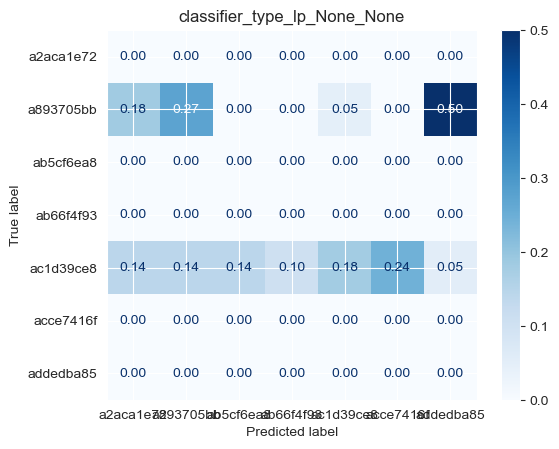

In [6]:
curr_features = features[feature_key]['val_features'][cv_index]
curr_label = features[feature_key]['val_label'][cv_index]
test_labels = []
len_to_test = 100
for i in range(len(curr_features[:len_to_test])):

    if i % 10 == 0: print(i)

    speakers_scores = []
    for speaker in sls['labels_set']:

        speaker_hmm = classifiers[speaker]
        speakers_scores.append(speaker_hmm.score(curr_features[i]))

    arg_max_speaker = np.argmax(speakers_scores)
    test_labels.append(arg_max_speaker)

performance_metrics = utils.get_performance_metrics(np.array(test_labels), curr_label[:len_to_test],
                                                    labels=list(sls['num_to_label'].keys()))

disp = ConfusionMatrixDisplay(confusion_matrix=performance_metrics['cm'],
                              display_labels=list(sls['label_to_num'].keys()))
disp.plot(cmap=plt.cm.Blues, values_format='.2f')
plt.title('classifier_type' + '_' + feature_key)
plt.show()
plt.close()